# 1. Setup

### Import dependecies

In [1]:
import cv2
import os
import numpy as np
import random
import matplotlib.pyplot as plt
import uuid
from tensorflow.keras.metrics import Precision, Recall

In [2]:
# import Tensorflow functional API

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

### Set GPU growth

In [3]:
# Avoid out of memory error by setting GPU memory consumption growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

### Create folder structure 

In [4]:
POSITIVE_PATH = os.path.join('data', 'positive')
NEGATIVE_PATH = os.path.join('data', 'negative')
ANCHOR_PATH = os.path.join('data', 'anchor')

# creating directories

# os.makedirs(POSITIVE_PATH)
# os.makedirs(NEGATIVE_PATH)
# os.makedirs(ANCHOR_PATH)

# 2. Collect images

### Untar labelled faces in the wild dataset

In [5]:
# uncompress tar gz file
# !tar -xf lfw.tgz

In [7]:
# move LFW images tothe following repository data/negative

for directory in os.listdir('lfw'):
    file_path = os.path.join('lfw', directory)
    for file in os.listdir(file_path):
        EXISING_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEGATIVE_PATH, file)
        os.replace(EXISING_PATH, NEW_PATH)

### Collect Positive and anchor images

In [ ]:
# establishing a connection to webcam

cap = cv2.VideoCapture(0)

while cap.isOpened():
    
    ret, frame = cap.read()
    
    # cut down frame to 250px*250px
    frame = frame[120:120+250, 200:200+250,:]
    
    # collect anchor images
    if cv2.waitKey(1) & 0XFF == ord('a'):
        
        image_name = os.path.join(ANCHOR_PATH, '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(image_name,frame)
    
    # collect positive images
    if cv2.waitKey(1) & 0XFF == ord('p'):
        
        image_name = os.path.join(POSITIVE_PATH, '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(image_name,frame)
    
    
    # show image back to screen
    cv2.imshow('Image Collection', frame)
    
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
cap.release()
cv2.destroyAllWindows()

In [ ]:
plt.imshow(frame)

### Data Augmentation

In [8]:
def data_aug(img):
    data = []
    for i in range(9):
        img = tf.image.stateless_random_brightness(img, max_delta=0.02, seed=(1,2))
        img = tf.image.stateless_random_contrast(img, lower=0.6, upper=1, seed=(1,3))
        # img = tf.image.stateless_random_crop(img, size=(20,20,3), seed=(1,2))
        img = tf.image.stateless_random_flip_left_right(img, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_jpeg_quality(img, min_jpeg_quality=90, max_jpeg_quality=100, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_saturation(img, lower=0.9,upper=1, seed=(np.random.randint(100),np.random.randint(100)))
            
        data.append(img)
    
    return data

In [9]:
# trying on an image in anchor folder

img_path = os.path.join(ANCHOR_PATH, '7d4adc99-343a-11ed-9e4d-c8b29b0ea9b0.jpg')
img = cv2.imread(img_path)
augmented_images = data_aug(img)

for image in augmented_images:
    cv2.imwrite(os.path.join(ANCHOR_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

#### First we passed POSITIVE images folder and now we passed ANCHOR images folder

In [12]:
for file_name in os.listdir(os.path.join(ANCHOR_PATH)):
    img_path = os.path.join(ANCHOR_PATH, file_name)
    img = cv2.imread(img_path)
    augmented_images = data_aug(img) 
    
    for image in augmented_images:
        cv2.imwrite(os.path.join(ANCHOR_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

# 3. Load Preprocess images

### Get image directories

In [5]:
# To create a dataset of all files matching a pattern, use tf.data.Dataset.list_files:

anchor = tf.data.Dataset.list_files(ANCHOR_PATH + '\*.jpg').take(5000)
positive = tf.data.Dataset.list_files(POSITIVE_PATH + '\*.jpg').take(5000)
negative = tf.data.Dataset.list_files(NEGATIVE_PATH + '\*.jpg').take(5000)

In [6]:
dir_test = anchor.as_numpy_iterator()

In [7]:
dir_test.next()

b'data\\anchor\\5b6b0aa8-376d-11ed-b614-c8b29b0ea9b0.jpg'

### Preprocessing: Scale and Resize

In [8]:
def preprocess(file_path):
    
    """
        In this function, we first read in the image and then load the image.
        After this we resize the image into 100px * 100px * 3 color channels.
        Last line helps in scaling.
    """
    byte_image = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(byte_image)  # loading of image
    img = tf.image.resize(img, (100,100))
    img = img/255.0
    
    return img

### Create labelled dataset

In [9]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [10]:
samples = data.as_numpy_iterator()

In [11]:
example = samples.next()

### Build train and test partition

In [12]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [13]:
res = preprocess_twin(*example)

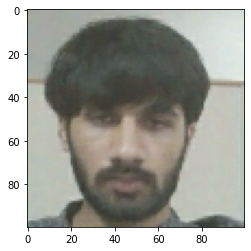

In [14]:
plt.imshow(res[0])

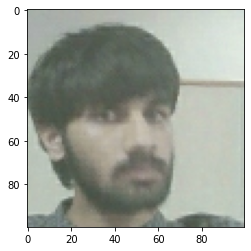

In [15]:
plt.imshow(res[1])

In [16]:
res[2]

1.0

In [17]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=10000)

In [18]:
data_samples = data.as_numpy_iterator()

In [19]:
s = data_samples.next()

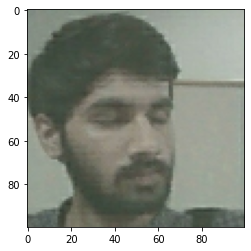

In [20]:
plt.imshow(s[0])

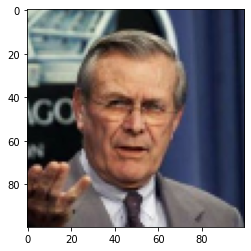

In [21]:
plt.imshow(s[1])

In [22]:
s[2]

0.0

In [23]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [24]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

# 4. Model Engineering

### Build embedding layers

In [25]:
def make_embedding():
    inp = Input(shape = (100,100,3),name ='input_image')
    
    # First block of model
    
    # we are passing inp as a connecting layer. This is a part of Tensorflow functional API
    c1 = Conv2D(64,(10,10),activation = 'relu')(inp) 
    m1 = MaxPooling2D(64,(2,2), padding = 'same')(c1)
    
    # Second block of model
    c2= Conv2D(128,(7,7), activation = 'relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding = 'same')(c2)
    
    # Third block of model
    c3 = Conv2D(128, (4,4), activation = 'relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding = 'same')(c3)
    
    # Final embedding layer
    
    c4 = Conv2D(256, (4,4), activation = 'relu')(m3)
    
    # f1 flattens the above layer into one dimension
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation = 'sigmoid')(f1)
    
    
    return Model(inputs = [inp], outputs = [d1], name = 'embedding')

In [26]:
embedding = make_embedding()

In [27]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 46, 46, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)       26

### Build distance layer

In [28]:
# Creating L1Distance layer for Siamese network

class L1Dist(Layer):
    
    def __init__(self, **kwargs):
        
        # inherits the __init__ constructor from Layer class
        super().__init__()
        
    def call(self, input_embedding, validation_embedding):
        # Calculates the similarity between two image embeddings
        
        return tf.math.abs(input_embedding - validation_embedding)

In [29]:
l1 = L1Dist()

### Build siamese model

In [30]:
def make_siamese_model():
    
    # take anchor image as input
    input_image = Input(name = 'input_image', shape = (100,100,3))
    
    # take validation image as input
    validation_image = Input(name = 'validation_image', shape = (100,100,3))
    
    
    # create an object of L1Dist 
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # output layer
    classifier = Dense(1, activation = 'sigmoid')(distances)
    
    return Model(inputs = [input_image, validation_image], outputs = classifier, name = 'SiameseNetwork')

In [31]:
siamese_model = make_siamese_model()

In [32]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_image (InputLayer)  [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_image[0][0]',            
                                                                  'validation_image[0

# Model Training

### Setup loss and optimizer

In [33]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [34]:
# 1e-4 is 0.0001 and it is the learning rate

opt = tf.keras.optimizers.Adam(1e-4)

### Establish checkpoints

In [35]:
"""
    To reload the model from the checkpoint:
        use model.load("path to checkpoint")
    This will load the pre-trained weights into
    the existing model
"""

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [36]:
checkpoint_prefix

'./training_checkpoints\\ckpt'

### Build train step function

In [37]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
        
    # Return loss
    return loss

### Build training loop

In [38]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Creating a metric object 
        r = Recall()
        p = Precision()
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat) 
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

### Train the model

In [39]:
EPOCHS = 50

In [42]:
train(train_data, EPOCHS)


 Epoch 1/50
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
1/1 [==============================] - 0s 288ms/step


1/1 [==============================] - 0s 278ms/step


438/438 [==============================] - 199s 424ms/step
0.13505666 0.93287235 0.99477726

 Epoch 2/50
1/1 [==============================] - 0s 287ms/step


1/1 [==============================] - 0s 276ms/step


1/1 [==============================] - 0s 264ms/step


438/438 [==============================] - 185s 422ms/step
0.0045727524 0.9920567 0.99857223

 Epoch 3/50
1/1 [==============================] - 0s 314ms/step


1/1 [==============================] - 0s 273ms/step


1/1 [==============================] - 0s 254ms/step


438/438 [==============================] - 183s 417ms/step
0.0074843704 0.9867359 0.99650556

 Epoch 4/50
1/1 [==============================] - 0s 270ms/step


1/1 [==============================] - 0s 273ms/step


1/1 [==============================] - 0s 278ms/step


438/438 [==============================] - 184s 421ms/step
0.0003329849 0.99478865 0.99970907

 Epoch 5/50
1/1 [==============================] - 0s 209ms/step


1/1 [==============================] - 0s 264ms/step


1/1 [==============================] - 0s 267ms/step


438/438 [==============================] - 186s 424ms/step
0.13711645 0.9888412 0.99942166

 Epoch 6/50
1/1 [==============================] - 0s 282ms/step


1/1 [==============================] - 0s 273ms/step


1/1 [==============================] - 0s 265ms/step


438/438 [==============================] - 186s 424ms/step
0.015049713 0.99434227 0.99971557

 Epoch 7/50
1/1 [==============================] - 0s 268ms/step


1/1 [==============================] - 0s 260ms/step


1/1 [==============================] - 0s 271ms/step


438/438 [==============================] - 183s 419ms/step
5.915901e-06 0.995461 1.0

 Epoch 8/50
1/1 [==============================] - 0s 263ms/step


1/1 [==============================] - 0s 260ms/step


438/438 [==============================] - 181s 413ms/step
-0.0 0.99856734 0.9997131

 Epoch 9/50
1/1 [==============================] - 0s 261ms/step


1/1 [==============================] - 0s 258ms/step


1/1 [==============================] - 0s 265ms/step


438/438 [==============================] - 180s 411ms/step
0.00047176043 0.9951205 0.99971163

 Epoch 10/50
1/1 [==============================] - 0s 260ms/step


1/1 [==============================] - 0s 251ms/step


1/1 [==============================] - 0s 256ms/step


438/438 [==============================] - 179s 409ms/step
0.016591353 0.9954338 0.99971336

 Epoch 11/50
1/1 [==============================] - 0s 256ms/step


1/1 [==============================] - 0s 257ms/step


1/1 [==============================] - 0s 258ms/step


438/438 [==============================] - 175s 399ms/step
0.0016217846 0.9977182 1.0

 Epoch 12/50
1/1 [==============================] - 0s 258ms/step


1/1 [==============================] - 0s 260ms/step


1/1 [==============================] - 0s 258ms/step


438/438 [==============================] - 175s 400ms/step
0.0055567464 0.99626327 1.0

 Epoch 13/50
1/1 [==============================] - 0s 256ms/step


1/1 [==============================] - 0s 261ms/step


1/1 [==============================] - 0s 240ms/step


438/438 [==============================] - 174s 398ms/step
1.6168806e-05 0.99516356 0.99573016

 Epoch 14/50
1/1 [==============================] - 0s 247ms/step


1/1 [==============================] - 0s 255ms/step


1/1 [==============================] - 0s 239ms/step


438/438 [==============================] - 173s 396ms/step
0.07658802 0.9968652 0.9997142

 Epoch 15/50
1/1 [==============================] - 0s 236ms/step


1/1 [==============================] - 0s 239ms/step


438/438 [==============================] - 167s 381ms/step
0.026500946 0.99601024 0.99885684

 Epoch 16/50
1/1 [==============================] - 0s 237ms/step


1/1 [==============================] - 0s 236ms/step


1/1 [==============================] - 0s 242ms/step


438/438 [==============================] - 167s 381ms/step
0.0019637663 0.99829257 1.0

 Epoch 17/50
1/1 [==============================] - 0s 239ms/step


1/1 [==============================] - 0s 239ms/step


1/1 [==============================] - 0s 242ms/step


438/438 [==============================] - 168s 383ms/step
0.015049298 0.99687856 0.99971545

 Epoch 18/50
1/1 [==============================] - 0s 244ms/step


1/1 [==============================] - 0s 250ms/step


1/1 [==============================] - 0s 238ms/step


438/438 [==============================] - 168s 383ms/step
0.018126493 0.9948674 1.0

 Epoch 19/50
1/1 [==============================] - 0s 239ms/step


1/1 [==============================] - 0s 238ms/step


1/1 [==============================] - 0s 240ms/step


438/438 [==============================] - 166s 380ms/step
0.008232512 0.9988558 1.0

 Epoch 20/50
1/1 [==============================] - 0s 239ms/step


1/1 [==============================] - 0s 239ms/step


1/1 [==============================] - 0s 237ms/step


438/438 [==============================] - 167s 380ms/step
0.0027289025 0.9985661 1.0

 Epoch 21/50
1/1 [==============================] - 0s 239ms/step


1/1 [==============================] - 0s 241ms/step


1/1 [==============================] - 0s 243ms/step


438/438 [==============================] - 166s 378ms/step
0.00028883218 0.99770904 0.99971306

 Epoch 22/50
1/1 [==============================] - 0s 243ms/step


1/1 [==============================] - 0s 242ms/step


438/438 [==============================] - 166s 379ms/step
8.597186e-05 0.9988479 0.99971175

 Epoch 23/50
1/1 [==============================] - 0s 235ms/step


1/1 [==============================] - 0s 237ms/step


1/1 [==============================] - 0s 243ms/step


438/438 [==============================] - 166s 380ms/step
0.0037780588 0.9988565 1.0

 Epoch 24/50
1/1 [==============================] - 0s 241ms/step


1/1 [==============================] - 0s 240ms/step


1/1 [==============================] - 0s 235ms/step


438/438 [==============================] - 165s 378ms/step
0.0015296952 0.999716 1.0

 Epoch 25/50
1/1 [==============================] - 0s 238ms/step


1/1 [==============================] - 0s 241ms/step


1/1 [==============================] - 0s 243ms/step


438/438 [==============================] - 167s 382ms/step
0.00458882 0.9945512 0.99971175

 Epoch 26/50
1/1 [==============================] - 0s 232ms/step


1/1 [==============================] - 0s 240ms/step


1/1 [==============================] - 0s 234ms/step


438/438 [==============================] - 165s 378ms/step
0.023253538 0.9991458 0.9997151

 Epoch 27/50
1/1 [==============================] - 0s 238ms/step


1/1 [==============================] - 0s 243ms/step


1/1 [==============================] - 0s 250ms/step


438/438 [==============================] - 168s 383ms/step
2.9802326e-08 0.99943775 1.0

 Epoch 28/50
1/1 [==============================] - 0s 242ms/step


1/1 [==============================] - 0s 243ms/step


1/1 [==============================] - 0s 235ms/step


438/438 [==============================] - 167s 381ms/step
0.00026891215 0.9982906 0.9994295

 Epoch 29/50
1/1 [==============================] - 0s 239ms/step


1/1 [==============================] - 0s 237ms/step


438/438 [==============================] - 169s 387ms/step
0.00015051781 0.9991429 1.0

 Epoch 30/50
1/1 [==============================] - 0s 223ms/step


1/1 [==============================] - 0s 246ms/step


1/1 [==============================] - 0s 244ms/step


438/438 [==============================] - 172s 393ms/step
2.5928164e-06 1.0 1.0

 Epoch 31/50
1/1 [==============================] - 0s 248ms/step


1/1 [==============================] - 0s 254ms/step


1/1 [==============================] - 0s 252ms/step


438/438 [==============================] - 170s 389ms/step
0.00032459706 0.9948557 0.9985657

 Epoch 32/50
1/1 [==============================] - 0s 247ms/step


1/1 [==============================] - 0s 249ms/step


1/1 [==============================] - 0s 240ms/step


438/438 [==============================] - 170s 388ms/step
4.1387364e-05 1.0 1.0

 Epoch 33/50
1/1 [==============================] - 0s 228ms/step


1/1 [==============================] - 0s 245ms/step


1/1 [==============================] - 0s 243ms/step


438/438 [==============================] - 170s 389ms/step
0.04010924 0.9985771 0.9977253

 Epoch 34/50
1/1 [==============================] - 0s 248ms/step


1/1 [==============================] - 0s 237ms/step


1/1 [==============================] - 0s 234ms/step


438/438 [==============================] - 170s 389ms/step
0.004241856 0.9977038 0.9997124

 Epoch 35/50
1/1 [==============================] - 0s 241ms/step


1/1 [==============================] - 0s 241ms/step


1/1 [==============================] - 0s 241ms/step


438/438 [==============================] - 168s 384ms/step
2.39911e-06 0.99943054 1.0

 Epoch 36/50
1/1 [==============================] - 0s 235ms/step


1/1 [==============================] - 0s 240ms/step


438/438 [==============================] - 168s 384ms/step
0.0001995623 0.99914867 1.0

 Epoch 37/50
1/1 [==============================] - 0s 239ms/step


1/1 [==============================] - 0s 237ms/step


1/1 [==============================] - 0s 231ms/step


438/438 [==============================] - 168s 383ms/step
0.05655494 0.9988369 1.0

 Epoch 38/50
1/1 [==============================] - 0s 250ms/step


1/1 [==============================] - 0s 236ms/step


1/1 [==============================] - 0s 225ms/step


438/438 [==============================] - 166s 378ms/step
0.0005742367 0.99741673 0.9994248

 Epoch 39/50
1/1 [==============================] - 0s 240ms/step


1/1 [==============================] - 0s 246ms/step


1/1 [==============================] - 0s 225ms/step


438/438 [==============================] - 165s 377ms/step
0.0003619355 0.9994302 1.0

 Epoch 40/50
1/1 [==============================] - 0s 229ms/step


1/1 [==============================] - 0s 232ms/step


1/1 [==============================] - 0s 230ms/step


438/438 [==============================] - 167s 382ms/step
5.215407e-08 1.0 1.0

 Epoch 41/50
1/1 [==============================] - 0s 240ms/step


1/1 [==============================] - 0s 238ms/step


1/1 [==============================] - 0s 222ms/step


438/438 [==============================] - 173s 395ms/step
5.960466e-08 0.9994283 0.9985718

 Epoch 42/50
1/1 [==============================] - 0s 210ms/step


1/1 [==============================] - 0s 197ms/step


1/1 [==============================] - 0s 282ms/step


438/438 [==============================] - 197s 450ms/step
4.8280695e-06 0.9997131 1.0

 Epoch 43/50
1/1 [==============================] - 0s 283ms/step


1/1 [==============================] - 0s 289ms/step


438/438 [==============================] - 198s 451ms/step
-0.0 0.9997159 1.0

 Epoch 44/50
1/1 [==============================] - 0s 287ms/step


1/1 [==============================] - 0s 222ms/step


1/1 [==============================] - 0s 232ms/step


438/438 [==============================] - 176s 401ms/step
4.753619e-05 0.99943393 1.0

 Epoch 45/50
1/1 [==============================] - 0s 243ms/step


1/1 [==============================] - 0s 239ms/step


1/1 [==============================] - 0s 243ms/step


438/438 [==============================] - 172s 393ms/step
3.427272e-07 1.0 1.0

 Epoch 46/50
1/1 [==============================] - 0s 250ms/step


1/1 [==============================] - 0s 241ms/step


1/1 [==============================] - 0s 248ms/step


438/438 [==============================] - 173s 395ms/step
0.001279392 1.0 0.99971503

 Epoch 47/50
1/1 [==============================] - 0s 234ms/step


1/1 [==============================] - 0s 250ms/step


1/1 [==============================] - 0s 252ms/step


438/438 [==============================] - 173s 395ms/step
4.813124e-06 0.9994295 0.9997147

 Epoch 48/50
1/1 [==============================] - 0s 251ms/step


1/1 [==============================] - 0s 253ms/step


1/1 [==============================] - 0s 247ms/step


438/438 [==============================] - 173s 395ms/step
0.00021592398 0.99942595 1.0

 Epoch 49/50
1/1 [==============================] - 0s 241ms/step


1/1 [==============================] - 0s 247ms/step


1/1 [==============================] - 0s 243ms/step


438/438 [==============================] - 171s 391ms/step
0.02168295 0.9988739 0.99803096

 Epoch 50/50
1/1 [==============================] - 0s 247ms/step


1/1 [==============================] - 0s 247ms/step


438/438 [==============================] - 173s 395ms/step
0.00048209474 1.0 1.0


# 6. Evaluate the model

### Make Predictions

In [43]:
# get a batch of test data

test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [44]:
# predict results

y_hat = siamese_model.predict([test_input, test_val])
y_hat

1/1 [==============================] - 0s 20ms/step


array([[9.3462052e-07],
       [7.1970589e-07],
       [9.9999905e-01],
       [1.0000000e+00],
       [3.7106379e-06],
       [1.0000000e+00],
       [9.9997902e-01],
       [9.9997675e-01],
       [1.7668457e-07],
       [5.1751048e-08],
       [9.9941206e-01],
       [9.9999952e-01],
       [1.2174643e-06],
       [9.9963057e-01],
       [9.9999976e-01],
       [6.4753795e-07]], dtype=float32)

In [45]:
y_hat = [1 if prediction > 0.5 else 0 for prediction in y_hat]

In [46]:
y_hat

[0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0]

In [47]:
y_true

array([0., 0., 1., 1., 0., 1., 1., 1., 0., 0., 1., 1., 0., 1., 1., 0.],
      dtype=float32)

### Calculate metrics

In [48]:
m = Recall()
m.update_state(y_true, y_hat)
m.result().numpy()

1.0

In [49]:
# Creating a metric object 
m = Precision()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [50]:
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true,yhat) 

print(r.result().numpy(), p.result().numpy())

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 16ms/step
1.0 1.0


### Plot results

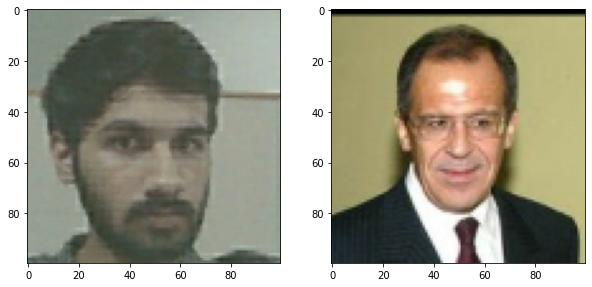

In [51]:
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[2])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[2])

# Renders cleanly
plt.show()

# 7. Save model

In [52]:
# Save weights
siamese_model.save('siamese_model_after_data_augmentation.h5')


In [53]:
# Reload model 
siamese_model = tf.keras.models.load_model('siamesemodel.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [54]:
# Make predictions with reloaded model
siamese_model.predict([test_input, test_val])

1/1 [==============================] - 0s 91ms/step


array([[1.4452095e-10],
       [8.7891839e-04],
       [2.5989511e-04],
       [7.0786541e-13],
       [5.8246388e-07],
       [6.3601208e-01],
       [1.8355452e-08],
       [9.9998093e-01]], dtype=float32)

In [55]:
# View model summary
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_image (InputLayer)  [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_image[0][0]',            
                                                                  'validation_image[0

# 8. Real-time testing

### Verification function

In [56]:
"""
    Access webcam and grab input image and verify the image in a number of positive samples
"""

'\n    Access webcam and grab input image and verify the image in a number of positive samples\n'

### Verification Function

In [57]:
def verify(model, detection_threshold, verification_threshold):
    
    """
        detection_threshold means the value above which a prediction is considered positive
        verification_threshold is proportion of positive predictions by total positive samples
    """
        
    # Build results array
    results = []
    
    
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

In [ ]:
cap = cv2.VideoCapture(0)

while cap.isOpened():
    
    ret, frame = cap.read()
    
    # cut down frame to 250px*250px
    frame = frame[120:120+250, 200:200+250,:]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        
        # Save input image to application_data/input_image folder 
        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        
        # Run verification
        results, verified = verify(siamese_model, 0.9, 0.75)
        print(verified)
    
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 17ms/step


In [60]:
np.sum(np.squeeze(results) > 0.8)

128

In [64]:
results

[array([[0.92258114]], dtype=float32),
 array([[0.75290847]], dtype=float32),
 array([[0.9652142]], dtype=float32),
 array([[0.7915313]], dtype=float32),
 array([[0.9659364]], dtype=float32),
 array([[0.9934516]], dtype=float32),
 array([[0.9692564]], dtype=float32),
 array([[0.9692564]], dtype=float32),
 array([[0.9692564]], dtype=float32),
 array([[0.9692564]], dtype=float32),
 array([[0.9692564]], dtype=float32),
 array([[0.97774076]], dtype=float32),
 array([[0.9862227]], dtype=float32),
 array([[0.99841523]], dtype=float32),
 array([[0.99942064]], dtype=float32),
 array([[0.99942064]], dtype=float32),
 array([[0.99942064]], dtype=float32),
 array([[0.99942064]], dtype=float32),
 array([[0.99942064]], dtype=float32),
 array([[0.99977666]], dtype=float32),
 array([[0.99999654]], dtype=float32),
 array([[0.99999654]], dtype=float32),
 array([[0.99999654]], dtype=float32),
 array([[0.99999654]], dtype=float32),
 array([[0.99999654]], dtype=float32),
 array([[1.]], dtype=float32),
 arr

# Refer this article to get better understanding of Siamese Network

### <https://towardsdatascience.com/siamese-networks-introduction-and-implementation-2140e3443dee>